<a href="https://colab.research.google.com/github/vihan-lakshman/mutagenic/blob/main/masking_pipeline_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation Dataset

In [26]:
!pip install Bio

In [27]:
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
#df = pd.read_csv('/content/prelim-deletion-validation-dataset-functional-annotations-with-interpro.csv')

In [28]:
esm3_test_df = pd.read_csv('/content/selectedrcsbpdb.tsv', sep='\t', header = None)

# Drop the last two columns
esm3_test_df = esm3_test_df.iloc[:, :-2]
esm3_test_df.columns = ["Protein Accession", "Seq Digest", "Seq Length", "Analysis", "Signature Accession", "Signature description", "Start location", "Stop location", "Score", "Status", "Date", "InterPro accession", "InterPro description"]

In [29]:
# prompt: read in InterProDescriptions.tsv and for all rows with GO:0016020 in its value for 'GO Terms', add the value for that row's 'Accession' value as part of a growing string separated by a semicolon. Then set it as the variable list_of_membrane_terms. don't name it df. name it interpro_go_df

interpro_go_df = pd.read_csv('/content/InterProDescriptions.tsv', sep='\t')

# Initialize an empty string to store the accessions
list_of_membrane_terms = ""

# Iterate through the DataFrame rows
for index, row in interpro_go_df.iterrows():
    go_terms = row['GO Terms']
    if isinstance(go_terms, str) and "GO:0016020" in go_terms:  # Check if the value is a string and contains "GO:0016020"
        accession = row['Accession']
        if isinstance(accession, str):  # Check if the accession is a string
          if list_of_membrane_terms == "":
            list_of_membrane_terms = accession
          else:
            list_of_membrane_terms += ';' + accession


In [31]:
merged_df = esm3_test_df.groupby('Protein Accession').agg({
    'Seq Length': 'first',
    'InterPro accession': lambda x: ';'.join(x[x != '-'].unique()),
    'InterPro description': lambda x: ';'.join(x[x != '-'].unique())
}).reset_index()

merged_df = merged_df.rename(columns={"InterPro accession": "InterPro_original", "InterPro description": "InterPro_original_description"})

# Add the new column
merged_df['InterPro_target'] = [list_of_membrane_terms] * len(merged_df)
df = merged_df
df

,Protein Accession,Seq Length,InterPro_original,InterPro_original_description,InterPro_target
0,5R1U_1|Chain,419,IPR034163; IPR021109; IPR001461; IPR001969; IP...,Aspergillopepsin-like catalytic domain; Aspart...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...
1,5R1Z_1|Chain,419,IPR034163; IPR021109; IPR001461; IPR001969; IP...,Aspergillopepsin-like catalytic domain; Aspart...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...
2,5R2B_1|Chain,419,IPR034163; IPR021109; IPR001461; IPR001969; IP...,Aspergillopepsin-like catalytic domain; Aspart...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...
3,5R2E_1|Chain,419,IPR034163; IPR021109; IPR001461; IPR001969; IP...,Aspergillopepsin-like catalytic domain; Aspart...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...
4,5R2J_1|Chain,419,IPR034163; IPR021109; IPR001461; IPR001969; IP...,Aspergillopepsin-like catalytic domain; Aspart...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...
...,...,...,...,...,...
231,9FX5_1|Chain,235,IPR001938; IPR037176; IPR017949,Thaumatin family; Osmotin/thaumatin-like super...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...
232,9GI7_1|Chain,129,IPR001916; IPR000974; IPR019799; IPR023346,"Glycoside hydrolase, family 22; Glycoside hydr...",IPR000015;IPR000018;IPR000021;IPR000025;IPR000...
233,9H3E_1|Chain,147,IPR000974; IPR023346; IPR019799; IPR001916,"Glycoside hydrolase, family 22, lysozyme; Lyso...",IPR000015;IPR000018;IPR000021;IPR000025;IPR000...
234,9HC2_1|Chain,129,IPR001916; IPR000974; IPR019799; IPR023346,"Glycoside hydrolase, family 22; Glycoside hydr...",IPR000015;IPR000018;IPR000021;IPR000025;IPR000...


In [33]:
from Bio import SeqIO
# Read FASTA file into a dictionary
def parse_fasta(fasta_file):
    fasta_dict = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        accession = record.id.split("|")[0]  # Extract only the part before the first "|"
        fasta_dict[accession] = str(record.seq)
    return fasta_dict

# Update DataFrame with sequences
def update_dataframe_with_sequences(df, fasta_dict):
    # Preprocess 'Protein Accession' column
    df["Protein Accession"] = df["Protein Accession"].str.split("|").str[0]
    df["Sequence"] = df["Protein Accession"].map(fasta_dict)
    return df

# Example usage
fasta_file = "/content/selectedrcsbpdb.fasta"
fasta_dict = parse_fasta(fasta_file)
df = update_dataframe_with_sequences(df, fasta_dict)

df

,Protein Accession,Seq Length,InterPro_original,InterPro_original_description,InterPro_target,Sequence
0,5R1U_1,419,IPR034163; IPR021109; IPR001461; IPR001969; IP...,Aspergillopepsin-like catalytic domain; Aspart...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...,MSSPLKNALVTAMLAGGALSSPTKQHVGIPVNASPEVGPGKYSFKQ...
1,5R1Z_1,419,IPR034163; IPR021109; IPR001461; IPR001969; IP...,Aspergillopepsin-like catalytic domain; Aspart...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...,MSSPLKNALVTAMLAGGALSSPTKQHVGIPVNASPEVGPGKYSFKQ...
2,5R2B_1,419,IPR034163; IPR021109; IPR001461; IPR001969; IP...,Aspergillopepsin-like catalytic domain; Aspart...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...,MSSPLKNALVTAMLAGGALSSPTKQHVGIPVNASPEVGPGKYSFKQ...
3,5R2E_1,419,IPR034163; IPR021109; IPR001461; IPR001969; IP...,Aspergillopepsin-like catalytic domain; Aspart...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...,MSSPLKNALVTAMLAGGALSSPTKQHVGIPVNASPEVGPGKYSFKQ...
4,5R2J_1,419,IPR034163; IPR021109; IPR001461; IPR001969; IP...,Aspergillopepsin-like catalytic domain; Aspart...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...,MSSPLKNALVTAMLAGGALSSPTKQHVGIPVNASPEVGPGKYSFKQ...
...,...,...,...,...,...,...
231,9FX5_1,235,IPR001938; IPR037176; IPR017949,Thaumatin family; Osmotin/thaumatin-like super...,IPR000015;IPR000018;IPR000021;IPR000025;IPR000...,MAATTCFFFLFPFLLLLTLSRAATFEIVNRCSYTVWAAASKGDAAL...
232,9GI7_1,129,IPR001916; IPR000974; IPR019799; IPR023346,"Glycoside hydrolase, family 22; Glycoside hydr...",IPR000015;IPR000018;IPR000021;IPR000025;IPR000...,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...
233,9H3E_1,147,IPR000974; IPR023346; IPR019799; IPR001916,"Glycoside hydrolase, family 22, lysozyme; Lyso...",IPR000015;IPR000018;IPR000021;IPR000025;IPR000...,MRSLLILVLCFLPLAALGKVFGRCELAAAMKRHGLDNYRGYSLGNW...
234,9HC2_1,129,IPR001916; IPR000974; IPR019799; IPR023346,"Glycoside hydrolase, family 22; Glycoside hydr...",IPR000015;IPR000018;IPR000021;IPR000025;IPR000...,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...


In [ ]:
# merged_df.to_csv('/content/merged_data.csv', index=False)

# # Download the file (for Google Colab)
# from google.colab import files
# files.download('/content/merged_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import random

# # List of standard amino acid single-letter codes
# amino_acids = "ACDEFGHIKLMNPQRSTVWY"

# def substitute_substring(sequence, del_start, del_end):
#     """Substitutes amino acids in a substring with random amino acids."""

#     # Adjust del_start to be 0-indexed
#     del_start -= 1

#     if del_start < 0 or del_end > len(sequence) or del_start >= del_end:
#         return sequence  # Handle invalid indices

#     substituted_seq = list(sequence)
#     for i in range(del_start, del_end):
#         substituted_seq[i] = random.choice(amino_acids)

#     return "".join(substituted_seq)


# # Apply the function to each row of the DataFrame
# df['substituted_seq'] = df.apply(lambda row: substitute_substring(row['sequence'], row['del_start'], row['del_end']), axis=1)
# df['substituted_seq'].head()

,substituted_seq
0,MRSRKLTGGVRSSARLRARSYSSASLASARDVTSSTSASGDRYTMT...
1,MDGAPVAEFRPTMTHGGRYLLYDIFGNKFEVTNKYQPPIMPIGRGA...
2,MSKRTTYCGLVTEAFLGQEITLKGWVNNRRDLGGLIFVDLRDREGI...
3,MAWLEDVDFLEDVPLLEDIPLLEDVPLLEDVPLLEDTSRLEDINLM...
4,MRYYEKIDGSKYRNIWVVGDLHGCYTNLMNKLDTIGFDNKKDLLIS...


In [34]:
# Dictionary to hold the results
embeddings_dict = {}

# Iterate through each row in the DataFrame
for _, row in df.iterrows():
    entry = row['Protein Accession']
    interpro_target = row['InterPro_target']
    interpro_original = row['InterPro_original']

    # Skip rows where 'Interpro' is None
    if pd.isna(interpro_target) or not interpro_target.strip() or pd.isna(interpro_original) or not interpro_target.strip():
        continue

    # Split the InterPro IDs by semicolons
    interpro_ids_target = interpro_target.split(';')
    interpro_ids_target = interpro_ids_target[:-1]
    interpro_ids_original = interpro_original.split(';')
    interpro_ids_original = interpro_ids_original[:-1]

    # Initialize entry in the dictionary if not present
    if entry not in embeddings_dict:
        embeddings_dict[entry] = {
            'InterPro_ids_target': interpro_ids_target,
            'InterPro_ids_original': interpro_ids_original
        }


In [51]:
first_key, first_value = next(iter(embeddings_dict.items()))
print(first_key, first_value['InterPro_ids_original'])

5R1U_1 ['IPR034163', ' IPR021109', ' IPR001461', ' IPR001969']


In [35]:
pip install esm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [38]:
from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESM3InferenceClient, ESMProtein, GenerationConfig

# Will instruct you how to get an API key from huggingface hub, make one with "Read" permission.
login()

In [39]:
model: ESM3InferenceClient = ESM3.from_pretrained("esm3_sm_open_v1").to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/3.06k [00:00<?, ?B/s]

data/1utn.pdb:   0%|          | 0.00/569k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.00 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

hyperplanes_8bit_58641.npz:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

data/entry_list_safety_29026.list:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

data/ParentChildTreeFile.txt:   0%|          | 0.00/595k [00:00<?, ?B/s]

hyperplanes_8bit_68103.npz:   0%|          | 0.00/34.9M [00:00<?, ?B/s]

(…)ata/interpro_29026_to_keywords_58641.csv:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

data/esm3_entry.list:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

data/interpro2keywords.csv:   0%|          | 0.00/7.32M [00:00<?, ?B/s]

(…)ord_vocabulary_safety_filtered_58641.txt:   0%|          | 0.00/788k [00:00<?, ?B/s]

data/keywords.txt:   0%|          | 0.00/788k [00:00<?, ?B/s]

data/tag_dict_4.json:   0%|          | 0.00/691k [00:00<?, ?B/s]

data/tag_dict_4_safety_filtered.json:   0%|          | 0.00/569k [00:00<?, ?B/s]

(…)0_residue_annotations_gt_1k_proteins.csv:   0%|          | 0.00/109k [00:00<?, ?B/s]

tfidf_safety_filtered_58641.pkl:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

esm3_function_decoder_v0.pth:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

esm3_structure_encoder_v0.pth:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

esm3_sm_open_v1.pth:   0%|          | 0.00/2.80G [00:00<?, ?B/s]

esm3_structure_decoder_v0.pth:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

keyword_idf_safety_filtered_58641.npy:   0%|          | 0.00/469k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/esm/pretrained.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [40]:
import torch.nn as nn
from esm.tokenization import InterProQuantizedTokenizer
from esm.utils.types import FunctionAnnotation
def get_keywords_from_interpro(
    interpro_annotations,
    interpro2keywords=InterProQuantizedTokenizer().interpro2keywords,
):
    keyword_annotations_list = []
    for interpro_annotation in interpro_annotations:
        keywords = interpro2keywords.get(interpro_annotation.label, [])
        keyword_annotations_list.extend([
            FunctionAnnotation(
                label=keyword,
                start=interpro_annotation.start,
                end=interpro_annotation.end,
            )
            for keyword in keywords
        ])
    return keyword_annotations_list

In [42]:
#protein that only has one function?
#longer sequences of all As, all Gs, or completely random
def get_label_embedding(interpro_label,sequence):
  hostProtein = ESMProtein(sequence=sequence)
  embedding_function = model.encoder.function_embed
  hostProtein.function_annotations = get_keywords_from_interpro([FunctionAnnotation(label=interpro_label, start=1, end=len(sequence))])
  hostProtein_tensor = model.encode(hostProtein)
  device = hostProtein_tensor.function.device  # Get the device of protein2_tensor.function
  embedding_function = embedding_function.to(device)  # Move embedding_function to the device

  function_embed = torch.cat(
      [
          embed_fn(funcs.to(device)) # Ensure funcs is on the same device
          for embed_fn, funcs in zip(
              embedding_function, hostProtein_tensor.function.unbind(-1)
          )
      ],
      -1,
  )

  if function_embed.shape[0] >= 3:
      row_sum = function_embed.sum(dim=0)  # Sum all rows
      row_avg = row_sum / (function_embed.shape[0] - 2)  # Divide by (number of rows - 2)
      row_avg_np = row_avg.cpu().detach().type(torch.float32).numpy()
      return row_avg_np
  else:
      return None

In [ ]:
import numpy as np
embedding_target_dict = {}  # Store the average embedding_target for each set of InterPro_ids_target

for entry, interpro_ids in embeddings_dict.items():
    # Check if the embedding_target for this set has already been calculated
    if tuple(interpro_ids['InterPro_ids_target']) not in embedding_target_dict:
        embeddings_target = []
        for interpro_id in interpro_ids['InterPro_ids_target']:
            embeddings_target.append(get_label_embedding(interpro_id, "A"))
        avg_embedding_target = np.mean(embeddings_target, axis=0)
        embedding_target_dict[tuple(interpro_ids['InterPro_ids_target'])] = avg_embedding_target
    else:
        avg_embedding_target = embedding_target_dict[tuple(interpro_ids['InterPro_ids_target'])]

    embeddings_dict[entry]['embedding_target'] = avg_embedding_target

    # Calculate embedding_original as before
    embeddings_original = []
    for interpro_id in interpro_ids['InterPro_ids_original']:
        embeddings_original.append(get_label_embedding(interpro_id, "A"))
    avg_embedding_original = np.mean(embeddings_original, axis=0)
    embeddings_dict[entry]['embedding_original'] = avg_embedding_original

In [50]:
first_key, first_value = next(iter(embeddings_dict.items()))
print(first_key, first_value)

5R1U_1 {'InterPro_ids_target': ['IPR000015', 'IPR000018', 'IPR000021', 'IPR000025', 'IPR000044', 'IPR000045', 'IPR000046', 'IPR000057', 'IPR000060', 'IPR000066', 'IPR000068', 'IPR000072', 'IPR000076', 'IPR000105', 'IPR000109', 'IPR000112', 'IPR000133', 'IPR000136', 'IPR000141', 'IPR000142', 'IPR000144', 'IPR000147', 'IPR000154', 'IPR000155', 'IPR000161', 'IPR000162', 'IPR000163', 'IPR000174', 'IPR000175', 'IPR000189', 'IPR000190', 'IPR000202', 'IPR000204', 'IPR000207', 'IPR000223', 'IPR000248', 'IPR000265', 'IPR000272', 'IPR000276', 'IPR000283', 'IPR000292', 'IPR000293', 'IPR000298', 'IPR000301', 'IPR000314', 'IPR000321', 'IPR000332', 'IPR000333', 'IPR000337', 'IPR000344', 'IPR000351', 'IPR000353', 'IPR000355', 'IPR000356', 'IPR000363', 'IPR000366', 'IPR000369', 'IPR000370', 'IPR000371', 'IPR000374', 'IPR000376', 'IPR000378', 'IPR000382', 'IPR000388', 'IPR000390', 'IPR000393', 'IPR000405', 'IPR000412', 'IPR000425', 'IPR000431', 'IPR000434', 'IPR000452', 'IPR000460', 'IPR000462', 'IPR00

In [ ]:
def embedding_masking_model(
    prompt,
    model,
    df,
    embeddings_dict,
    percentage=10,
):
    """
    Helper function to process a protein sequence, calculate similarities,
    and return indices for masking.

    Args:
        prompt (str): The protein sequence to be processed.
        model: The model used for protein generation and embeddings.
        df (pd.DataFrame): DataFrame containing protein data.
        embeddings_dict (dict): Dictionary storing embeddings and other details.

    Returns:
        List[int]: Indices used for masking in the sequence.
    """
    # Create an ESMProtein object
    protein = ESMProtein(sequence=prompt)

    # Configure the model for generation
    generation_config = GenerationConfig(track="function", num_steps=8)

    # Generate the protein
    generated_protein = model.generate(protein, generation_config)

    # Check if function annotations are available
    entry = df.loc[df['sequence'] == prompt, 'Protein Accession'].iloc[0]
    if generated_protein.function_annotations is None:
        embeddings_dict[entry]['hamming_distance'] = None
        return []

    # Getting embedding for the protein
    protein_tensor = model.encode(generated_protein)
    embedding_function = model.encoder.function_embed
    device = protein_tensor.function.device  # Get the device of protein_tensor.function
    embedding_function = embedding_function.to(device)  # Move embedding_function to the device

    function_embed = torch.cat(
        [
            embed_fn(funcs.to(device))  # Ensure funcs is on the same device
            for embed_fn, funcs in zip(
                embedding_function, protein_tensor.function.unbind(-1)
            )
        ],
        -1,
    )

    # Exclude start and end tokens
    function_embed = function_embed[1:-1, :]

    # Convert the protein_tensor.function to a NumPy array
    protein_np = function_embed.cpu().detach().type(torch.float32).numpy()

    # Retrieve embedding for target function's InterPro IDs (target function = function we're trying to add in addition to, not in place of, original)
    embedding_target = embeddings_dict[entry]['embedding_target']

    # Retrieve embedding for original function's InterPro IDs
    embedding_original = embeddings_dict[entry]['embedding_original']

    # Calculate cosine similarity
    similarities_target = cosine_similarity(protein_np, embedding_target.reshape(1, -1))
    similarities_original = cosine_similarity(protein_np, embedding_original.reshape(1, -1))

    # Get ranks for similarity from highest similarity to lowest similarity
    ranks_target = np.argsort(similarities_target.flatten())[::-1]
    ranks_original = np.argsort(similarities_original.flatten())[::-1]

    #Get number of indices to mask
    num_indices = int(len(prompt) * percentage / 100)

    # Ensure we select at least 1 index
    num_indices = max(1, num_indices)

    # Sum ranks and find top 10 indices with lowest (largest) rank
    ranks = ranks_target + ranks_original
    num_negated = -1*num_indices
    indices = np.argsort(ranks)[num_negated:]

    # Store the indices in the embeddings_dict
    embeddings_dict[entry]['indices'] = indices.tolist()

    return indices.tolist()

In [ ]:
def get_random_indices(prompt, percentage):
    """
    Randomly select indices to mask based on the percentage of the prompt's length.
    """
    num_indices = int(len(prompt) * percentage / 100)
    # Ensure we select at least one index
    num_indices = max(1, num_indices)

    # Randomly select unique indices to mask
    return random.sample(range(len(prompt)), num_indices)

In [ ]:
for idx, prompt in enumerate(df['sequence']):
  try:
    random_indices = get_random_indices(prompt, 8)
    # Replace locations in prompt corresponding to indices in 'indices' with "_"
    target_seq = df.loc[df['sequence'] == prompt, 'sequence'].iloc[0]
    entry = df.loc[df['sequence'] == prompt, 'Protein Accession'].iloc[0]
    if entry not in embeddings_dict:
        continue
    for method in ['embedding', 'random']:
      if method == 'embedding':
        indices = embedding_masking_model(prompt, model, df, embeddings_dict,percentage=8)
        if not indices:
          continue
      elif method == 'random':
        indices = get_random_indices(prompt, 8)
      modified_prompt = list(prompt)
      for index in indices:
          modified_prompt[index] = "_"
      modified_prompt = "".join(modified_prompt)
      protein_prompt = ESMProtein(sequence=modified_prompt)
      sequence_generation = model.generate(
          protein_prompt,
          GenerationConfig(
              track="sequence",
              num_steps=protein_prompt.sequence.count("_") // 2,
              temperature=0.5,
          ),
      )
      # print("Generated Sequence: " + str(sequence_generation.sequence))
      generated_sequence = sequence_generation.sequence
      # print("Target Sequence: " + str(target_seq))
      # Ensure sequences are of equal length
      if len(generated_sequence) != len(target_seq):
          raise ValueError("Sequences must be of the same length to calculate Hamming distance.")

      # Calculate Hamming distance
      hamming_distance = sum(1 for gen, target in zip(generated_sequence, target_seq) if gen != target)

      # Print results
      print(f'Index {idx}: {method} Hamming Distance:', hamming_distance)
      embeddings_dict[entry][f'{method}_hamming_distance'] = hamming_distance
      torch.cuda.empty_cache()
  except Exception as e:
    print(f"An error occurred for index {idx}: {e}")
    continue

100%|██████████| 9/9 [00:00<00:00, 13.46it/s]


Index 0: random Hamming Distance: 25


100%|██████████| 14/14 [00:01<00:00, 12.96it/s]


Index 1: embedding Hamming Distance: 43


100%|██████████| 14/14 [00:01<00:00, 13.27it/s]


Index 1: random Hamming Distance: 29


100%|██████████| 23/23 [00:01<00:00, 12.92it/s]


Index 2: embedding Hamming Distance: 165


100%|██████████| 23/23 [00:01<00:00, 13.46it/s]


Index 2: random Hamming Distance: 156


100%|██████████| 10/10 [00:00<00:00, 13.21it/s]


Index 3: random Hamming Distance: 20


100%|██████████| 8/8 [00:00<00:00, 12.58it/s]


Index 4: embedding Hamming Distance: 80


100%|██████████| 8/8 [00:00<00:00, 13.16it/s]


Index 4: random Hamming Distance: 84


100%|██████████| 16/16 [00:01<00:00, 12.30it/s]


Index 5: embedding Hamming Distance: 32


100%|██████████| 16/16 [00:01<00:00, 13.40it/s]


Index 5: random Hamming Distance: 32


100%|██████████| 6/6 [00:00<00:00, 12.71it/s]


Index 6: embedding Hamming Distance: 59


100%|██████████| 6/6 [00:00<00:00, 13.13it/s]


Index 6: random Hamming Distance: 63


100%|██████████| 17/17 [00:01<00:00, 13.23it/s]


Index 7: embedding Hamming Distance: 209


100%|██████████| 17/17 [00:01<00:00, 13.61it/s]


Index 7: random Hamming Distance: 205


100%|██████████| 14/14 [00:01<00:00, 12.95it/s]


Index 8: embedding Hamming Distance: 186


100%|██████████| 14/14 [00:01<00:00, 13.41it/s]


Index 8: random Hamming Distance: 189


100%|██████████| 7/7 [00:00<00:00, 12.74it/s]


Index 9: embedding Hamming Distance: 73


100%|██████████| 7/7 [00:00<00:00, 13.03it/s]


Index 9: random Hamming Distance: 79


100%|██████████| 16/16 [00:01<00:00, 13.16it/s]


Index 10: embedding Hamming Distance: 23


100%|██████████| 16/16 [00:01<00:00, 13.34it/s]


Index 10: random Hamming Distance: 17


100%|██████████| 52/52 [00:06<00:00,  7.72it/s]


Index 11: embedding Hamming Distance: 243


100%|██████████| 52/52 [00:06<00:00,  7.78it/s]


Index 11: random Hamming Distance: 225


100%|██████████| 33/33 [00:02<00:00, 13.33it/s]


Index 12: random Hamming Distance: 347


100%|██████████| 4/4 [00:00<00:00, 12.40it/s]


Index 13: embedding Hamming Distance: 22


100%|██████████| 4/4 [00:00<00:00, 13.29it/s]


Index 13: random Hamming Distance: 22


100%|██████████| 31/31 [00:02<00:00, 13.23it/s]


Index 14: embedding Hamming Distance: 75


100%|██████████| 31/31 [00:02<00:00, 13.19it/s]


Index 14: random Hamming Distance: 67


100%|██████████| 12/12 [00:00<00:00, 12.97it/s]


Index 15: embedding Hamming Distance: 34


100%|██████████| 12/12 [00:00<00:00, 13.29it/s]


Index 15: random Hamming Distance: 38


100%|██████████| 17/17 [00:01<00:00, 13.33it/s]


Index 16: embedding Hamming Distance: 89


100%|██████████| 17/17 [00:01<00:00, 13.03it/s]


Index 16: random Hamming Distance: 85


100%|██████████| 8/8 [00:00<00:00, 12.81it/s]


Index 17: embedding Hamming Distance: 58


100%|██████████| 8/8 [00:00<00:00, 13.14it/s]


Index 17: random Hamming Distance: 58


100%|██████████| 55/55 [00:07<00:00,  7.41it/s]


Index 18: embedding Hamming Distance: 161


100%|██████████| 55/55 [00:07<00:00,  7.27it/s]


Index 18: random Hamming Distance: 159


100%|██████████| 16/16 [00:01<00:00, 13.21it/s]


Index 19: embedding Hamming Distance: 281


100%|██████████| 16/16 [00:01<00:00, 13.45it/s]


Index 19: random Hamming Distance: 265


100%|██████████| 8/8 [00:00<00:00, 12.63it/s]


Index 20: embedding Hamming Distance: 49


100%|██████████| 8/8 [00:00<00:00, 13.25it/s]


Index 20: random Hamming Distance: 44


100%|██████████| 15/15 [00:01<00:00, 13.09it/s]


Index 21: embedding Hamming Distance: 81


100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


Index 21: random Hamming Distance: 75


100%|██████████| 11/11 [00:00<00:00, 12.96it/s]


Index 22: embedding Hamming Distance: 47


100%|██████████| 11/11 [00:00<00:00, 13.12it/s]


Index 22: random Hamming Distance: 57


100%|██████████| 10/10 [00:00<00:00, 12.78it/s]


Index 23: embedding Hamming Distance: 13


100%|██████████| 10/10 [00:00<00:00, 13.19it/s]


Index 23: random Hamming Distance: 14


100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


Index 24: random Hamming Distance: 85


100%|██████████| 4/4 [00:00<00:00, 12.20it/s]


Index 25: embedding Hamming Distance: 10


100%|██████████| 4/4 [00:00<00:00, 13.44it/s]


Index 25: random Hamming Distance: 9


100%|██████████| 17/17 [00:01<00:00, 13.05it/s]


Index 26: embedding Hamming Distance: 56


100%|██████████| 17/17 [00:01<00:00, 13.38it/s]


Index 26: random Hamming Distance: 54


100%|██████████| 39/39 [00:03<00:00, 11.99it/s]


Index 27: embedding Hamming Distance: 171


100%|██████████| 39/39 [00:03<00:00, 12.08it/s]


Index 27: random Hamming Distance: 157


100%|██████████| 17/17 [00:01<00:00, 13.16it/s]


Index 28: embedding Hamming Distance: 105


100%|██████████| 17/17 [00:01<00:00, 13.05it/s]


Index 28: random Hamming Distance: 116


100%|██████████| 20/20 [00:01<00:00, 13.04it/s]


Index 29: embedding Hamming Distance: 63


100%|██████████| 20/20 [00:01<00:00, 13.14it/s]


Index 29: random Hamming Distance: 57


100%|██████████| 8/8 [00:00<00:00, 13.17it/s]


Index 30: random Hamming Distance: 137


100%|██████████| 9/9 [00:00<00:00, 12.91it/s]


Index 31: embedding Hamming Distance: 168


100%|██████████| 9/9 [00:00<00:00, 13.06it/s]


Index 31: random Hamming Distance: 174


100%|██████████| 23/23 [00:01<00:00, 13.11it/s]


Index 32: embedding Hamming Distance: 223


100%|██████████| 23/23 [00:01<00:00, 13.19it/s]


Index 32: random Hamming Distance: 207


100%|██████████| 10/10 [00:00<00:00, 12.77it/s]


Index 33: embedding Hamming Distance: 16


100%|██████████| 10/10 [00:00<00:00, 12.96it/s]


Index 33: random Hamming Distance: 26


100%|██████████| 18/18 [00:01<00:00, 12.58it/s]


Index 34: embedding Hamming Distance: 66


100%|██████████| 18/18 [00:01<00:00, 13.31it/s]


Index 34: random Hamming Distance: 52


100%|██████████| 17/17 [00:01<00:00, 12.98it/s]


Index 35: embedding Hamming Distance: 23


100%|██████████| 17/17 [00:01<00:00, 13.36it/s]


Index 35: random Hamming Distance: 22


100%|██████████| 13/13 [00:00<00:00, 13.22it/s]


Index 36: embedding Hamming Distance: 117


100%|██████████| 13/13 [00:00<00:00, 13.29it/s]


Index 36: random Hamming Distance: 129


100%|██████████| 4/4 [00:00<00:00, 12.25it/s]


Index 37: embedding Hamming Distance: 69


100%|██████████| 4/4 [00:00<00:00, 12.66it/s]


Index 37: random Hamming Distance: 63


100%|██████████| 10/10 [00:00<00:00, 13.02it/s]


Index 38: random Hamming Distance: 70


100%|██████████| 5/5 [00:00<00:00, 13.43it/s]


Index 39: random Hamming Distance: 28


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Index 40: random Hamming Distance: 18


100%|██████████| 17/17 [00:01<00:00, 13.01it/s]


Index 41: embedding Hamming Distance: 148


100%|██████████| 17/17 [00:01<00:00, 13.22it/s]


Index 41: random Hamming Distance: 145


100%|██████████| 12/12 [00:00<00:00, 13.09it/s]


Index 42: random Hamming Distance: 282


100%|██████████| 20/20 [00:01<00:00, 13.10it/s]


Index 43: embedding Hamming Distance: 52


100%|██████████| 20/20 [00:01<00:00, 13.19it/s]


Index 43: random Hamming Distance: 34


100%|██████████| 52/52 [00:06<00:00,  7.79it/s]


Index 44: embedding Hamming Distance: 404


100%|██████████| 52/52 [00:06<00:00,  7.75it/s]


Index 44: random Hamming Distance: 470


100%|██████████| 27/27 [00:02<00:00, 13.11it/s]


Index 45: embedding Hamming Distance: 85


100%|██████████| 27/27 [00:02<00:00, 13.15it/s]


Index 45: random Hamming Distance: 76


100%|██████████| 9/9 [00:00<00:00, 12.78it/s]


Index 46: embedding Hamming Distance: 45


100%|██████████| 9/9 [00:00<00:00, 13.19it/s]


Index 46: random Hamming Distance: 42


100%|██████████| 13/13 [00:01<00:00, 12.93it/s]


Index 47: embedding Hamming Distance: 37


100%|██████████| 13/13 [00:00<00:00, 13.26it/s]


Index 47: random Hamming Distance: 38


100%|██████████| 18/18 [00:01<00:00, 12.92it/s]


Index 48: embedding Hamming Distance: 65


100%|██████████| 18/18 [00:01<00:00, 13.21it/s]


Index 48: random Hamming Distance: 72


100%|██████████| 16/16 [00:01<00:00, 13.11it/s]


Index 49: embedding Hamming Distance: 102


100%|██████████| 16/16 [00:01<00:00, 13.36it/s]


Index 49: random Hamming Distance: 91


100%|██████████| 9/9 [00:00<00:00, 12.72it/s]


Index 50: embedding Hamming Distance: 12


100%|██████████| 9/9 [00:00<00:00, 13.15it/s]


Index 50: random Hamming Distance: 27


100%|██████████| 17/17 [00:01<00:00, 13.06it/s]


Index 51: embedding Hamming Distance: 51


100%|██████████| 17/17 [00:01<00:00, 13.29it/s]


Index 51: random Hamming Distance: 49


100%|██████████| 4/4 [00:00<00:00, 12.23it/s]


Index 52: embedding Hamming Distance: 75


100%|██████████| 4/4 [00:00<00:00, 13.11it/s]


Index 52: random Hamming Distance: 79


100%|██████████| 6/6 [00:00<00:00, 12.57it/s]


Index 53: embedding Hamming Distance: 81


100%|██████████| 6/6 [00:00<00:00, 13.04it/s]


Index 53: random Hamming Distance: 77


100%|██████████| 7/7 [00:00<00:00, 12.62it/s]


Index 54: embedding Hamming Distance: 15


100%|██████████| 7/7 [00:00<00:00, 12.90it/s]


Index 54: random Hamming Distance: 7


100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


Index 55: embedding Hamming Distance: 42


100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


Index 55: random Hamming Distance: 40


100%|██████████| 19/19 [00:01<00:00, 13.03it/s]


Index 56: embedding Hamming Distance: 196


100%|██████████| 19/19 [00:01<00:00, 13.22it/s]


Index 56: random Hamming Distance: 205


100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


Index 57: embedding Hamming Distance: 82


100%|██████████| 5/5 [00:00<00:00, 12.36it/s]


Index 57: random Hamming Distance: 77


100%|██████████| 2/2 [00:00<00:00, 11.45it/s]


Index 58: embedding Hamming Distance: 16


100%|██████████| 2/2 [00:00<00:00, 12.91it/s]


Index 58: random Hamming Distance: 18


100%|██████████| 6/6 [00:00<00:00, 12.54it/s]


Index 59: embedding Hamming Distance: 71


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]


Index 59: random Hamming Distance: 69


100%|██████████| 14/14 [00:01<00:00, 12.92it/s]


Index 60: embedding Hamming Distance: 12


100%|██████████| 14/14 [00:01<00:00, 13.22it/s]


Index 60: random Hamming Distance: 23


100%|██████████| 23/23 [00:01<00:00, 12.86it/s]


Index 61: embedding Hamming Distance: 201


100%|██████████| 23/23 [00:01<00:00, 13.21it/s]


Index 61: random Hamming Distance: 214


100%|██████████| 10/10 [00:00<00:00, 12.82it/s]


Index 62: embedding Hamming Distance: 77


100%|██████████| 10/10 [00:00<00:00, 13.23it/s]


Index 62: random Hamming Distance: 79


100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


Index 63: embedding Hamming Distance: 30


100%|██████████| 8/8 [00:00<00:00, 13.18it/s]


Index 63: random Hamming Distance: 40


100%|██████████| 20/20 [00:01<00:00, 12.79it/s]


Index 64: embedding Hamming Distance: 43


100%|██████████| 20/20 [00:01<00:00, 13.38it/s]


Index 64: random Hamming Distance: 29


100%|██████████| 17/17 [00:01<00:00, 13.11it/s]


Index 65: embedding Hamming Distance: 140


100%|██████████| 17/17 [00:01<00:00, 13.39it/s]


Index 65: random Hamming Distance: 131


100%|██████████| 13/13 [00:00<00:00, 13.02it/s]


Index 66: embedding Hamming Distance: 27


100%|██████████| 13/13 [00:00<00:00, 13.20it/s]


Index 66: random Hamming Distance: 20


100%|██████████| 17/17 [00:01<00:00, 13.01it/s]


Index 67: embedding Hamming Distance: 88


100%|██████████| 17/17 [00:01<00:00, 13.12it/s]


Index 67: random Hamming Distance: 92


100%|██████████| 9/9 [00:00<00:00, 12.87it/s]


Index 68: embedding Hamming Distance: 16


100%|██████████| 9/9 [00:00<00:00, 13.21it/s]


Index 68: random Hamming Distance: 14


100%|██████████| 16/16 [00:01<00:00, 13.11it/s]


Index 69: embedding Hamming Distance: 146


100%|██████████| 16/16 [00:01<00:00, 13.41it/s]


Index 69: random Hamming Distance: 145


100%|██████████| 6/6 [00:00<00:00, 12.48it/s]


Index 70: embedding Hamming Distance: 15


100%|██████████| 6/6 [00:00<00:00, 13.18it/s]


Index 70: random Hamming Distance: 15


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]


Index 71: embedding Hamming Distance: 15


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]


Index 71: random Hamming Distance: 18


100%|██████████| 8/8 [00:00<00:00, 12.70it/s]


Index 72: embedding Hamming Distance: 16


100%|██████████| 8/8 [00:00<00:00, 13.14it/s]


Index 72: random Hamming Distance: 10


100%|██████████| 51/51 [00:06<00:00,  8.07it/s]


Index 73: embedding Hamming Distance: 82


100%|██████████| 51/51 [00:06<00:00,  8.04it/s]


Index 73: random Hamming Distance: 69


100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


Index 74: embedding Hamming Distance: 22


100%|██████████| 2/2 [00:00<00:00, 13.06it/s]


Index 74: random Hamming Distance: 23


100%|██████████| 11/11 [00:00<00:00, 12.86it/s]


Index 75: embedding Hamming Distance: 209


100%|██████████| 11/11 [00:00<00:00, 13.09it/s]


Index 75: random Hamming Distance: 211


100%|██████████| 11/11 [00:00<00:00, 12.72it/s]


Index 76: embedding Hamming Distance: 30


100%|██████████| 11/11 [00:00<00:00, 13.03it/s]


Index 76: random Hamming Distance: 38


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


Index 77: random Hamming Distance: 38


100%|██████████| 10/10 [00:00<00:00, 12.86it/s]


Index 78: embedding Hamming Distance: 21


100%|██████████| 10/10 [00:00<00:00, 13.28it/s]


Index 78: random Hamming Distance: 21


100%|██████████| 14/14 [00:01<00:00, 13.14it/s]


Index 79: embedding Hamming Distance: 157


100%|██████████| 14/14 [00:01<00:00, 12.99it/s]


Index 79: random Hamming Distance: 157


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]


Index 80: embedding Hamming Distance: 28


100%|██████████| 6/6 [00:00<00:00, 12.99it/s]


Index 80: random Hamming Distance: 24


100%|██████████| 21/21 [00:01<00:00, 13.11it/s]


Index 81: embedding Hamming Distance: 85


100%|██████████| 21/21 [00:01<00:00, 13.37it/s]


Index 81: random Hamming Distance: 76


100%|██████████| 16/16 [00:01<00:00, 13.01it/s]


Index 82: embedding Hamming Distance: 69


100%|██████████| 16/16 [00:01<00:00, 13.20it/s]


Index 82: random Hamming Distance: 75


100%|██████████| 51/51 [00:06<00:00,  8.06it/s]


Index 83: embedding Hamming Distance: 553


100%|██████████| 51/51 [00:06<00:00,  8.05it/s]


Index 83: random Hamming Distance: 585


100%|██████████| 7/7 [00:00<00:00, 12.66it/s]


Index 84: embedding Hamming Distance: 12


100%|██████████| 7/7 [00:00<00:00, 13.25it/s]


Index 84: random Hamming Distance: 9


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]


Index 85: embedding Hamming Distance: 6


100%|██████████| 6/6 [00:00<00:00, 13.21it/s]


Index 85: random Hamming Distance: 8


100%|██████████| 3/3 [00:00<00:00, 12.07it/s]


Index 86: embedding Hamming Distance: 14


100%|██████████| 3/3 [00:00<00:00, 12.60it/s]


Index 86: random Hamming Distance: 17


100%|██████████| 15/15 [00:01<00:00, 13.19it/s]


Index 87: embedding Hamming Distance: 13


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


Index 87: random Hamming Distance: 21


100%|██████████| 6/6 [00:00<00:00, 12.65it/s]


Index 88: embedding Hamming Distance: 67


100%|██████████| 6/6 [00:00<00:00, 12.99it/s]


Index 88: random Hamming Distance: 65


100%|██████████| 9/9 [00:00<00:00, 12.62it/s]


Index 89: embedding Hamming Distance: 87


100%|██████████| 9/9 [00:00<00:00, 12.88it/s]


Index 89: random Hamming Distance: 74


100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


Index 90: embedding Hamming Distance: 25


100%|██████████| 5/5 [00:00<00:00, 13.13it/s]


Index 90: random Hamming Distance: 21


100%|██████████| 5/5 [00:00<00:00, 12.29it/s]


Index 91: embedding Hamming Distance: 47


100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


Index 91: random Hamming Distance: 47


100%|██████████| 26/26 [00:01<00:00, 13.15it/s]


Index 92: embedding Hamming Distance: 363


100%|██████████| 26/26 [00:01<00:00, 13.26it/s]


Index 92: random Hamming Distance: 360


100%|██████████| 13/13 [00:01<00:00, 12.59it/s]


Index 93: embedding Hamming Distance: 105


100%|██████████| 13/13 [00:00<00:00, 13.20it/s]


Index 93: random Hamming Distance: 104


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]


Index 94: embedding Hamming Distance: 71


100%|██████████| 6/6 [00:00<00:00, 13.05it/s]


Index 94: random Hamming Distance: 70


100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


Index 95: embedding Hamming Distance: 15


100%|██████████| 8/8 [00:00<00:00, 13.16it/s]


Index 95: random Hamming Distance: 9


100%|██████████| 14/14 [00:01<00:00, 12.98it/s]


Index 96: embedding Hamming Distance: 75


100%|██████████| 14/14 [00:01<00:00, 13.30it/s]


Index 96: random Hamming Distance: 76


100%|██████████| 18/18 [00:01<00:00, 13.05it/s]


Index 97: embedding Hamming Distance: 295


100%|██████████| 18/18 [00:01<00:00, 13.27it/s]


Index 97: random Hamming Distance: 297


100%|██████████| 23/23 [00:01<00:00, 13.06it/s]


Index 98: embedding Hamming Distance: 300


100%|██████████| 23/23 [00:01<00:00, 13.29it/s]


Index 98: random Hamming Distance: 286


100%|██████████| 25/25 [00:01<00:00, 13.17it/s]


Index 99: embedding Hamming Distance: 19


100%|██████████| 25/25 [00:01<00:00, 13.34it/s]


Index 99: random Hamming Distance: 17


100%|██████████| 36/36 [00:02<00:00, 12.87it/s]


Index 100: embedding Hamming Distance: 440


100%|██████████| 36/36 [00:02<00:00, 12.96it/s]


Index 100: random Hamming Distance: 462


100%|██████████| 2/2 [00:00<00:00, 13.21it/s]


Index 101: random Hamming Distance: 34


100%|██████████| 7/7 [00:00<00:00, 12.72it/s]


Index 102: embedding Hamming Distance: 6


100%|██████████| 7/7 [00:00<00:00, 13.17it/s]


Index 102: random Hamming Distance: 8


100%|██████████| 23/23 [00:01<00:00, 13.15it/s]


Index 103: embedding Hamming Distance: 190


100%|██████████| 23/23 [00:01<00:00, 13.10it/s]


Index 103: random Hamming Distance: 203


100%|██████████| 15/15 [00:01<00:00, 13.14it/s]


Index 104: embedding Hamming Distance: 190


100%|██████████| 15/15 [00:01<00:00, 13.28it/s]


Index 104: random Hamming Distance: 201


100%|██████████| 30/30 [00:02<00:00, 13.21it/s]


Index 105: embedding Hamming Distance: 101


100%|██████████| 30/30 [00:02<00:00, 13.26it/s]


Index 105: random Hamming Distance: 96


100%|██████████| 23/23 [00:01<00:00, 13.04it/s]


Index 106: embedding Hamming Distance: 258


100%|██████████| 23/23 [00:01<00:00, 13.30it/s]


Index 106: random Hamming Distance: 253


100%|██████████| 4/4 [00:00<00:00, 12.26it/s]


Index 107: embedding Hamming Distance: 10


100%|██████████| 4/4 [00:00<00:00, 13.08it/s]


Index 107: random Hamming Distance: 7


100%|██████████| 16/16 [00:01<00:00, 13.07it/s]


Index 108: embedding Hamming Distance: 53


100%|██████████| 16/16 [00:01<00:00, 13.28it/s]


Index 108: random Hamming Distance: 52


100%|██████████| 9/9 [00:00<00:00, 12.68it/s]


Index 109: embedding Hamming Distance: 154


100%|██████████| 9/9 [00:00<00:00, 13.08it/s]


Index 109: random Hamming Distance: 152


100%|██████████| 20/20 [00:01<00:00, 13.22it/s]


Index 110: embedding Hamming Distance: 45


100%|██████████| 20/20 [00:01<00:00, 13.42it/s]


Index 110: random Hamming Distance: 42


100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


Index 111: embedding Hamming Distance: 6


100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


Index 111: random Hamming Distance: 5


100%|██████████| 7/7 [00:00<00:00, 12.66it/s]


Index 112: embedding Hamming Distance: 74


100%|██████████| 7/7 [00:00<00:00, 12.81it/s]


Index 112: random Hamming Distance: 82


100%|██████████| 3/3 [00:00<00:00, 13.00it/s]


Index 113: random Hamming Distance: 13


100%|██████████| 13/13 [00:00<00:00, 13.05it/s]


Index 114: embedding Hamming Distance: 22


100%|██████████| 13/13 [00:00<00:00, 13.06it/s]


Index 114: random Hamming Distance: 21


100%|██████████| 20/20 [00:01<00:00, 13.23it/s]


Index 115: embedding Hamming Distance: 205


100%|██████████| 20/20 [00:01<00:00, 13.32it/s]


Index 115: random Hamming Distance: 216


100%|██████████| 12/12 [00:00<00:00, 13.31it/s]


Index 116: random Hamming Distance: 251


100%|██████████| 9/9 [00:00<00:00, 12.52it/s]


Index 117: embedding Hamming Distance: 23


100%|██████████| 9/9 [00:00<00:00, 13.15it/s]


Index 117: random Hamming Distance: 19


100%|██████████| 6/6 [00:00<00:00, 12.53it/s]


Index 118: embedding Hamming Distance: 38


100%|██████████| 6/6 [00:00<00:00, 13.18it/s]


Index 118: random Hamming Distance: 41


100%|██████████| 14/14 [00:01<00:00, 13.10it/s]


Index 119: embedding Hamming Distance: 87


100%|██████████| 14/14 [00:01<00:00, 13.25it/s]


Index 119: random Hamming Distance: 81


100%|██████████| 10/10 [00:00<00:00, 13.13it/s]


Index 120: embedding Hamming Distance: 59


100%|██████████| 10/10 [00:00<00:00, 12.96it/s]


Index 120: random Hamming Distance: 56


100%|██████████| 4/4 [00:00<00:00, 12.06it/s]


Index 121: embedding Hamming Distance: 35


100%|██████████| 4/4 [00:00<00:00, 13.19it/s]


Index 121: random Hamming Distance: 37


100%|██████████| 10/10 [00:00<00:00, 12.79it/s]


Index 122: embedding Hamming Distance: 54


100%|██████████| 10/10 [00:00<00:00, 13.32it/s]


Index 122: random Hamming Distance: 55


100%|██████████| 9/9 [00:00<00:00, 13.10it/s]


Index 124: random Hamming Distance: 191


100%|██████████| 3/3 [00:00<00:00, 12.08it/s]


Index 125: embedding Hamming Distance: 8


100%|██████████| 3/3 [00:00<00:00, 13.04it/s]


Index 125: random Hamming Distance: 5


100%|██████████| 4/4 [00:00<00:00, 10.95it/s]


Index 126: embedding Hamming Distance: 13


100%|██████████| 4/4 [00:00<00:00, 13.05it/s]


Index 126: random Hamming Distance: 10


100%|██████████| 11/11 [00:00<00:00, 13.16it/s]


Index 127: random Hamming Distance: 205


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


Index 128: embedding Hamming Distance: 4


100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Index 128: random Hamming Distance: 6


100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


Index 129: embedding Hamming Distance: 26


100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


Index 129: random Hamming Distance: 25


100%|██████████| 14/14 [00:01<00:00, 13.04it/s]


Index 130: embedding Hamming Distance: 15


100%|██████████| 14/14 [00:01<00:00, 13.17it/s]


Index 130: random Hamming Distance: 13


100%|██████████| 13/13 [00:01<00:00, 12.84it/s]


Index 131: embedding Hamming Distance: 79


100%|██████████| 13/13 [00:00<00:00, 13.01it/s]


Index 131: random Hamming Distance: 67


100%|██████████| 6/6 [00:00<00:00, 13.24it/s]


Index 132: random Hamming Distance: 125


100%|██████████| 22/22 [00:01<00:00, 12.89it/s]


Index 133: embedding Hamming Distance: 247


100%|██████████| 22/22 [00:01<00:00, 13.11it/s]


Index 133: random Hamming Distance: 254


100%|██████████| 9/9 [00:00<00:00, 12.72it/s]


Index 134: embedding Hamming Distance: 135


100%|██████████| 9/9 [00:00<00:00, 13.21it/s]


Index 134: random Hamming Distance: 129


100%|██████████| 7/7 [00:00<00:00, 12.75it/s]


Index 135: embedding Hamming Distance: 59


100%|██████████| 7/7 [00:00<00:00, 13.21it/s]


Index 135: random Hamming Distance: 59


100%|██████████| 13/13 [00:00<00:00, 13.06it/s]


Index 136: random Hamming Distance: 75


100%|██████████| 14/14 [00:01<00:00, 13.10it/s]


Index 137: random Hamming Distance: 318


100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


Index 138: embedding Hamming Distance: 12


100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


Index 138: random Hamming Distance: 13


100%|██████████| 13/13 [00:01<00:00, 12.83it/s]


Index 139: embedding Hamming Distance: 28


100%|██████████| 13/13 [00:00<00:00, 13.22it/s]


Index 139: random Hamming Distance: 15


100%|██████████| 22/22 [00:01<00:00, 13.23it/s]


Index 140: embedding Hamming Distance: 76


100%|██████████| 22/22 [00:01<00:00, 13.26it/s]


Index 140: random Hamming Distance: 74


100%|██████████| 16/16 [00:01<00:00, 13.14it/s]


Index 141: embedding Hamming Distance: 102


100%|██████████| 16/16 [00:01<00:00, 13.21it/s]


Index 141: random Hamming Distance: 94


100%|██████████| 7/7 [00:00<00:00, 12.25it/s]


Index 142: embedding Hamming Distance: 20


100%|██████████| 7/7 [00:00<00:00, 13.12it/s]


Index 142: random Hamming Distance: 26


100%|██████████| 15/15 [00:01<00:00, 12.83it/s]


Index 143: embedding Hamming Distance: 52


100%|██████████| 15/15 [00:01<00:00, 13.32it/s]


Index 143: random Hamming Distance: 62


100%|██████████| 11/11 [00:00<00:00, 13.12it/s]


Index 144: embedding Hamming Distance: 37


100%|██████████| 11/11 [00:00<00:00, 13.40it/s]


Index 144: random Hamming Distance: 34


100%|██████████| 11/11 [00:00<00:00, 12.92it/s]


Index 145: embedding Hamming Distance: 29


100%|██████████| 11/11 [00:00<00:00, 13.19it/s]


Index 145: random Hamming Distance: 28


100%|██████████| 10/10 [00:00<00:00, 12.59it/s]


Index 146: embedding Hamming Distance: 66


100%|██████████| 10/10 [00:00<00:00, 13.09it/s]


Index 146: random Hamming Distance: 61


100%|██████████| 57/57 [00:08<00:00,  7.09it/s]


Index 147: embedding Hamming Distance: 113


100%|██████████| 57/57 [00:08<00:00,  6.98it/s]


Index 147: random Hamming Distance: 122


100%|██████████| 9/9 [00:00<00:00, 12.81it/s]


Index 148: embedding Hamming Distance: 132


100%|██████████| 9/9 [00:00<00:00, 13.06it/s]


Index 148: random Hamming Distance: 124


100%|██████████| 18/18 [00:01<00:00, 12.97it/s]


Index 149: embedding Hamming Distance: 179


100%|██████████| 18/18 [00:01<00:00, 13.23it/s]


Index 149: random Hamming Distance: 175


100%|██████████| 31/31 [00:02<00:00, 13.08it/s]


Index 150: embedding Hamming Distance: 234


100%|██████████| 31/31 [00:02<00:00, 13.35it/s]


Index 150: random Hamming Distance: 217


100%|██████████| 14/14 [00:01<00:00, 13.12it/s]


Index 151: embedding Hamming Distance: 51


100%|██████████| 14/14 [00:01<00:00, 13.25it/s]


Index 151: random Hamming Distance: 43


100%|██████████| 19/19 [00:01<00:00, 13.00it/s]


Index 152: embedding Hamming Distance: 96


100%|██████████| 19/19 [00:01<00:00, 13.29it/s]


Index 152: random Hamming Distance: 101


100%|██████████| 7/7 [00:00<00:00, 12.68it/s]


Index 154: embedding Hamming Distance: 9


100%|██████████| 7/7 [00:00<00:00, 13.20it/s]


Index 154: random Hamming Distance: 4


100%|██████████| 4/4 [00:00<00:00, 13.51it/s]


Index 155: random Hamming Distance: 33


100%|██████████| 11/11 [00:00<00:00, 12.95it/s]


Index 156: embedding Hamming Distance: 82


100%|██████████| 11/11 [00:00<00:00, 13.09it/s]


Index 156: random Hamming Distance: 76


100%|██████████| 10/10 [00:00<00:00, 12.59it/s]


Index 157: embedding Hamming Distance: 21


100%|██████████| 10/10 [00:00<00:00, 13.25it/s]


Index 157: random Hamming Distance: 17


100%|██████████| 7/7 [00:00<00:00, 13.14it/s]


Index 158: random Hamming Distance: 71


100%|██████████| 12/12 [00:00<00:00, 12.73it/s]


Index 159: embedding Hamming Distance: 20


100%|██████████| 12/12 [00:00<00:00, 13.10it/s]


Index 159: random Hamming Distance: 14


100%|██████████| 26/26 [00:01<00:00, 13.29it/s]


Index 160: random Hamming Distance: 129


100%|██████████| 62/62 [00:10<00:00,  6.07it/s]


Index 161: embedding Hamming Distance: 201


100%|██████████| 62/62 [00:10<00:00,  5.93it/s]


Index 161: random Hamming Distance: 173


100%|██████████| 12/12 [00:00<00:00, 12.71it/s]


Index 162: embedding Hamming Distance: 64


100%|██████████| 12/12 [00:00<00:00, 13.00it/s]


Index 162: random Hamming Distance: 67


100%|██████████| 4/4 [00:00<00:00, 12.17it/s]


Index 163: embedding Hamming Distance: 14


100%|██████████| 4/4 [00:00<00:00, 12.83it/s]


Index 163: random Hamming Distance: 12


100%|██████████| 9/9 [00:00<00:00, 12.92it/s]


Index 164: embedding Hamming Distance: 52


100%|██████████| 9/9 [00:00<00:00, 13.13it/s]


Index 164: random Hamming Distance: 55


100%|██████████| 2/2 [00:00<00:00, 11.25it/s]


Index 165: embedding Hamming Distance: 9


100%|██████████| 2/2 [00:00<00:00, 13.03it/s]


Index 165: random Hamming Distance: 6


100%|██████████| 12/12 [00:00<00:00, 12.80it/s]


Index 166: embedding Hamming Distance: 117


100%|██████████| 12/12 [00:00<00:00, 12.50it/s]


Index 166: random Hamming Distance: 115


100%|██████████| 7/7 [00:00<00:00, 12.55it/s]


Index 167: embedding Hamming Distance: 9


100%|██████████| 7/7 [00:00<00:00, 13.10it/s]


Index 167: random Hamming Distance: 5


100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


Index 168: random Hamming Distance: 53


100%|██████████| 6/6 [00:00<00:00, 12.13it/s]


Index 169: embedding Hamming Distance: 6


100%|██████████| 6/6 [00:00<00:00, 13.26it/s]


Index 169: random Hamming Distance: 11


100%|██████████| 6/6 [00:00<00:00, 12.03it/s]


Index 170: embedding Hamming Distance: 29


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]


Index 170: random Hamming Distance: 24


100%|██████████| 6/6 [00:00<00:00, 13.20it/s]


Index 171: random Hamming Distance: 103


100%|██████████| 7/7 [00:00<00:00, 12.29it/s]


Index 172: embedding Hamming Distance: 118


100%|██████████| 7/7 [00:00<00:00, 12.96it/s]


Index 172: random Hamming Distance: 122


100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


Index 173: random Hamming Distance: 12


100%|██████████| 14/14 [00:01<00:00, 12.60it/s]


Index 174: embedding Hamming Distance: 30


100%|██████████| 14/14 [00:01<00:00, 13.09it/s]


Index 174: random Hamming Distance: 24


100%|██████████| 7/7 [00:00<00:00, 12.33it/s]


Index 175: embedding Hamming Distance: 7


100%|██████████| 7/7 [00:00<00:00, 12.79it/s]


Index 175: random Hamming Distance: 15


100%|██████████| 9/9 [00:00<00:00, 12.56it/s]


Index 176: embedding Hamming Distance: 111


100%|██████████| 9/9 [00:00<00:00, 12.75it/s]


Index 176: random Hamming Distance: 114


100%|██████████| 16/16 [00:01<00:00, 13.06it/s]


Index 177: embedding Hamming Distance: 185


100%|██████████| 16/16 [00:01<00:00, 13.33it/s]


Index 177: random Hamming Distance: 188


100%|██████████| 12/12 [00:00<00:00, 12.30it/s]


Index 178: embedding Hamming Distance: 103


100%|██████████| 12/12 [00:00<00:00, 13.39it/s]


Index 178: random Hamming Distance: 102


100%|██████████| 7/7 [00:00<00:00, 13.34it/s]


Index 179: random Hamming Distance: 98


100%|██████████| 17/17 [00:01<00:00, 12.86it/s]


Index 180: embedding Hamming Distance: 62


100%|██████████| 17/17 [00:01<00:00, 13.13it/s]


Index 180: random Hamming Distance: 67


100%|██████████| 6/6 [00:00<00:00, 13.34it/s]


Index 181: random Hamming Distance: 45


100%|██████████| 6/6 [00:00<00:00, 12.17it/s]


Index 182: embedding Hamming Distance: 79


100%|██████████| 6/6 [00:00<00:00, 12.75it/s]


Index 182: random Hamming Distance: 73


100%|██████████| 15/15 [00:01<00:00, 12.94it/s]


Index 183: embedding Hamming Distance: 13


100%|██████████| 15/15 [00:01<00:00, 12.97it/s]


Index 183: random Hamming Distance: 8


100%|██████████| 41/41 [00:03<00:00, 10.81it/s]


Index 184: embedding Hamming Distance: 258


100%|██████████| 41/41 [00:03<00:00, 10.84it/s]


Index 184: random Hamming Distance: 261


100%|██████████| 15/15 [00:01<00:00, 12.59it/s]


Index 185: embedding Hamming Distance: 147


100%|██████████| 15/15 [00:01<00:00, 13.10it/s]


Index 185: random Hamming Distance: 135


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]


Index 186: embedding Hamming Distance: 22


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]


Index 186: random Hamming Distance: 16


100%|██████████| 7/7 [00:00<00:00, 12.67it/s]


Index 187: embedding Hamming Distance: 36


100%|██████████| 7/7 [00:00<00:00, 12.99it/s]


Index 187: random Hamming Distance: 40


100%|██████████| 17/17 [00:01<00:00, 13.22it/s]


Index 188: random Hamming Distance: 165


100%|██████████| 21/21 [00:01<00:00, 13.01it/s]


Index 189: embedding Hamming Distance: 124


100%|██████████| 21/21 [00:01<00:00, 13.26it/s]


Index 189: random Hamming Distance: 135


100%|██████████| 4/4 [00:00<00:00, 11.96it/s]


Index 190: embedding Hamming Distance: 14


100%|██████████| 4/4 [00:00<00:00, 12.67it/s]


Index 190: random Hamming Distance: 11


100%|██████████| 6/6 [00:00<00:00, 12.10it/s]


Index 191: embedding Hamming Distance: 5


100%|██████████| 6/6 [00:00<00:00, 12.92it/s]


Index 191: random Hamming Distance: 7


100%|██████████| 11/11 [00:00<00:00, 13.10it/s]


Index 192: random Hamming Distance: 156


100%|██████████| 14/14 [00:01<00:00, 12.69it/s]


Index 193: embedding Hamming Distance: 169


100%|██████████| 14/14 [00:01<00:00, 12.62it/s]


Index 193: random Hamming Distance: 173


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]


Index 194: embedding Hamming Distance: 19


100%|██████████| 6/6 [00:00<00:00, 13.00it/s]


Index 194: random Hamming Distance: 14


100%|██████████| 29/29 [00:02<00:00, 13.10it/s]


Index 195: embedding Hamming Distance: 80


100%|██████████| 29/29 [00:02<00:00, 13.21it/s]


Index 195: random Hamming Distance: 87


100%|██████████| 3/3 [00:00<00:00, 13.09it/s]


Index 196: random Hamming Distance: 52


100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


Index 197: embedding Hamming Distance: 38


100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


Index 197: random Hamming Distance: 37


100%|██████████| 11/11 [00:00<00:00, 12.98it/s]


Index 198: embedding Hamming Distance: 61


100%|██████████| 11/11 [00:00<00:00, 13.02it/s]


Index 198: random Hamming Distance: 62


100%|██████████| 14/14 [00:01<00:00, 12.81it/s]


Index 199: embedding Hamming Distance: 113


100%|██████████| 14/14 [00:01<00:00, 13.09it/s]

Index 199: random Hamming Distance: 110


0.23663477841474406
0.16891755335583075
0.23387537453248966
0.17095937778785902


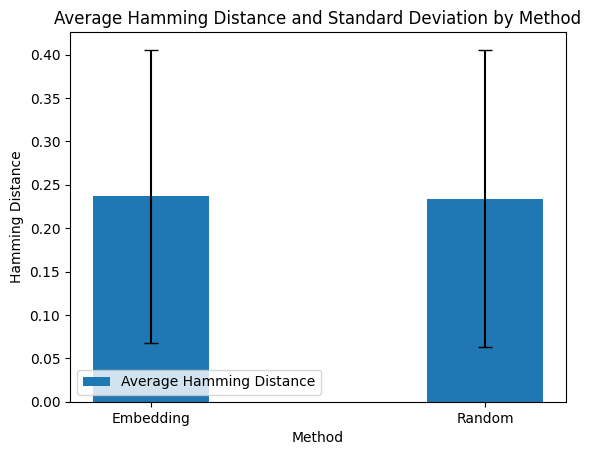

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract Hamming distances for 'embedding' and 'random' methods
embedding_distances = []
random_distances = []

# Iterate over embeddings_dict to gather the hamming distances
for key, entry in embeddings_dict.items():
    embedding_distance = entry.get('embedding_hamming_distance', None)
    random_distance = entry.get('random_hamming_distance', None)
    seq_length = len(df.loc[df['Protein Accession'] == key, 'sequence'].iloc[0])
    embeddings_dict[key]['seq_length'] = seq_length

    # Skip None values and collect valid distances (only compare on proteins w/ both values)
    if embedding_distance is not None and random_distance is not None:
        embedding_distances.append(embedding_distance/seq_length)
        random_distances.append(random_distance/seq_length)

# Calculate average and standard deviation for both methods
embedding_avg = np.mean(embedding_distances) if embedding_distances else 0
embedding_std = np.std(embedding_distances) if embedding_distances else 0
print(embedding_avg)
print(embedding_std)

random_avg = np.mean(random_distances) if random_distances else 0
random_std = np.std(random_distances) if random_distances else 0
print(random_avg)
print(random_std)

# Prepare data for the bar plot
methods = ['Embedding', 'Random']
averages = [embedding_avg, random_avg]
std_devs = [embedding_std, random_std]

# Create the bar plot
fig, ax = plt.subplots()

# Set positions for the bars
bar_width = 0.35
index = np.arange(len(methods))

# Plot the bars with error bars
ax.bar(index, averages, bar_width, yerr=std_devs, capsize=5, label='Average Hamming Distance')

# Customize the plot
ax.set_xlabel('Method')
ax.set_ylabel('Hamming Distance')
ax.set_title('Average Hamming Distance and Standard Deviation by Method')
ax.set_xticks(index)
ax.set_xticklabels(methods)
ax.legend()

# Display the plot
plt.show()

In [ ]:
import json
import numpy as np

# Specify the file path where you want to save the JSON file
file_path = 'hamming_distance_dict.json'

# Define a custom encoder to handle NumPy arrays
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert NumPy array to list
        return json.JSONEncoder.default(self, obj)

# Save the dictionary to a JSON file using the custom encoder
with open(file_path, 'w') as json_file:
    json.dump(embeddings_dict, json_file, indent=4, cls=NumpyEncoder)
    # Use cls=NumpyEncoder to apply the custom encoding